In [1]:
%matplotlib inline
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
from pprint import pprint
import copy

from omnigloter import analyse_network as analysis


In [2]:
def target_frequency_error(target, spikes, power=1):
    err = []
    if power == 1:
        err[:] = [np.abs(len(times) - target) for times in spikes]
    else:
        err[:] = [np.abs(len(times) - target)**power for times in spikes]

    return np.sum(err)

def mean_target_frequency_error(target, spikes, power=1):
    return target_frequency_error(target, spikes, power) / float(len(spikes))

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def to_dict(npz):
    d = {}
    for k in npz:
        try:
            d[k] = npz[k].item()
        except:
            d[k] = npz[k]
    return d

def get_test_label_idx(data):
    n_class = data['params']['sim']['num_classes']
    n_train_per_class = data['params']['sim']['samples_per_class']
    n_epochs = data['params']['sim']['num_epochs']
    return n_class * n_train_per_class * n_epochs

def get_test_start_t(data):
    dt = data['params']['sim']['sample_dt']
    n_train = get_test_label_idx(data)
    return n_train * dt

def get_test_spikes_and_labels(data):
    spk = data['recs']['output'][0]['spikes']
    lbl = data['input']['labels']
    dt = data['params']['sim']['sample_dt']
    start_t = get_test_start_t(data)
    start_idx = get_test_label_idx(data)
    out_spk = []
    out_ids = lbl[start_idx:]
    for times in spk:
        ts = np.asarray(times)
        whr = np.where(ts >= start_t)
        out_spk.append(ts[whr])
    return out_spk, out_ids
        
DEF_MARKERS = ['v', '<', 'o', 's', 'P', '*', 'X', 'd', 'p'] * 2
cmap = matplotlib.cm.get_cmap('gist_rainbow')
DEF_COLORS = [cmap(v) for v in np.arange(0., 1., 1./20.)]
# ACTIVITY_THRESHOLD = 0.2 * NUM_OUTPUT
# ABOVE_THRESH_W = 0.5 / NUM_CLASSES
# MAX_VECTOR_DIST = 200.0

def vectors_above_threshold(vectors, threshold):
    vs = [np.sum(v) for v in vectors]
#     print(vs, threshold)
    return [i for i, s in enumerate(vs) if s >= threshold]

def plot_test_map(labels, spikes, start_t, dt, ms=1, markers=DEF_MARKERS, 
                  colors=DEF_COLORS, edgewidth=1):
    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    n_out = len(spikes)
    w = np.ceil(np.sqrt(n_out))
    
    for x in np.arange(w+1):
        plt.axvline(x, linewidth=1, color='gray')
        plt.axhline(x, linewidth=1, color='gray')

    for nid, times in enumerate(spikes): 
        y = nid // w
        x = nid % w
        for t in times:
            lbl_idx = int((t - start_t) // dt)
            if lbl_idx >= len(labels):
                continue
            lbl = labels[lbl_idx]
            mrk = markers[lbl]
            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 else None 
            clr = colors[lbl]
            counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
            
    handles, labels = plt.gca().get_legend_handles_labels()
    slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))

def plot_test_map_single(labels, spikes, start_t, dt, ms=1, 
                         markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1):
    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    n_out = len(spikes)
    w = np.ceil(np.sqrt(n_out))

    lbls_per_nrn = get_labels_per_neuron(labels, spikes, start_t, dt)
    ax = plt.gca()
    ax.set_title('Categories (symbol/color) per neuron (squares)')
    for x in np.arange(w+1):
        plt.plot([x, x], [0, w], '-', linewidth=1, color='gray')
        plt.plot([0, w], [x, x], '-', linewidth=1, color='gray')
#         plt.axvline(x, linewidth=1, color='gray')
#         plt.axhline(x, linewidth=1, color='gray')
        
    for nid, times in enumerate(spikes): 
        y = nid // w
        x = nid % w
        many = False
        unique_lbl_p_nrn = np.unique(lbls_per_nrn[nid])
        if len(unique_lbl_p_nrn) > 1:
            many = True
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=1,
                    edgecolor='black', facecolor='red', alpha=0.3,
                    fill=True, hatch='x')

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue
        elif len(unique_lbl_p_nrn) == 1:
            many = False
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=0,
                    edgecolor='none', facecolor='green', alpha=0.3)

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue

        for t in times:
            lbl_idx = int((t - start_t) // dt)
            if lbl_idx >= len(labels):
                continue
                
            lbl = labels[lbl_idx]
            mrk = markers[lbl]
            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 and not many else None 
            clr = colors[lbl]
            if not many:
                counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
    
    try:
        handles, labels = plt.gca().get_legend_handles_labels()
        slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))
    except:
        print("all neurons where activated by many classes")

    ax.set_xlim(0, w)
    ax.set_ylim(0, w)
    
    _ticks = 0.5 + np.arange(w)
    ax.set_yticks(_ticks)
    ax.set_yticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    ax.set_xticks(_ticks)
    ax.set_xticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    
    ax.set_xlabel(r'Neuron "$x \;coordinate$"')
    ax.set_ylabel(r'Neuron "$y \;coordinate$"')
    
def get_labels_per_neuron(labels, spikes, start_t, dt):
    lbls_per_nrn = {k: [] for k in range(len(spikes))}

    for nid, times in enumerate(spikes):
        ts = np.asarray(times).astype('int')
        ts -= int(start_t)
        ts //= int(dt)
        ids = ts[np.where(ts < len(labels))]
        for lbl in [labels[i] for i in ids]:
            lbls_per_nrn[nid].append(lbl)
    return lbls_per_nrn

def get_neurons_per_label(labels, spikes, start_t, dt):
    unique = np.unique(labels)
    nrns_per_lbl = {k: [] for k in unique}
    for nid, times in enumerate(spikes):
        ts = np.asarray(times).astype('int')
        ts -= int(start_t)
        ts //= int(dt)
        ids = ts[np.where(ts < len(labels))]
        for lbl in [labels[i] for i in ids]:
            nrns_per_lbl[lbl].append(nid)

    return nrns_per_lbl

def mean_per_sample_class_distance(_activity_per_sample, labels, n_out):
    return np.mean(
        per_sample_class_distance(_activity_per_sample, labels, n_out))

def per_sample_class_distance(_activity_per_sample, labels, n_out):
    class_samples = {}
    max_active = 0
    for idx, lbl in enumerate(labels):
        lbl_list = class_samples.get(lbl, [])
        lbl_list.append( _activity_per_sample[idx])
        class_samples[lbl] = lbl_list
        
        if len(_activity_per_sample[idx]) > max_active:
            max_active = len(_activity_per_sample[idx])

    if max_active == 0:
        return 0
    
    v0 = np.zeros(n_out)
    v1 = np.zeros(n_out)
    dists = []
    classes = sorted(class_samples.keys())
    for idx0, cls0 in enumerate(classes[:-1]):
        for cls1 in classes[idx0+1:]:
            for samp0 in class_samples[cls0]:
                v0[:] = 0
                if len(samp0):
                    v0[samp0] = 1
                for samp1 in class_samples[cls1]:
                    v1[:] = 0
                    if len(samp1):
                        v1[samp1] = 1
                    
                    dists.append( np.sum(np.abs(v0 - v1)) )

    return dists

def error_sample_target_activity(target, activity_per_sample):
    act = np.asarray([len(ids) for ids in activity_per_sample])
    return np.sum(np.abs(act - target))


def activity_per_sample(labels, spikes, start_t, dt):
    end_t = start_t + len(labels) * dt
    aps = [[] for _ in labels]
    for st in np.arange(start_t, end_t, dt):
        et = st + dt
        idx = int((st - start_t) // dt)
        for nid, times in enumerate(spikes):
            ts = np.asarray(times)
            whr = np.where(np.logical_and(st <= ts, ts < et))[0]
            if len(whr):
                aps[idx].append(nid)
    return aps


def get_max_t(spikes):
    max_t = -1
    max_id = -1
    for nid, times in enumerate(spikes):
        if len(times):
            local_max_t = np.max(times)
            if local_max_t > max_t:
                max_t = local_max_t
                max_id = nid
    return max_t, max_id


def get_vectors(neurons_per_label):
    vectors = {}
    for k in neurons_per_label:
        v = np.zeros(len(out_spikes))
        v[neurons_per_label[k]] = 1.
        vectors[k] = v
    return vectors

def mdist(v0, v1, normalize=True):
    s = 0.
    if np.sum(v0) >= 1 and np.sum(v1) >= 1:
        s = np.sum(np.abs(v0 - v1))
        if normalize:
            s *= 1./(np.sum(v0) + np.sum(v1))
    return s

def get_distances(neurons_per_label):
    n_labels = len(neurons_per_label)
    vectors = get_vectors(neurons_per_label)
    dists = np.zeros((n_labels, n_labels))
    labels = sorted(neurons_per_label.keys())
    for k0 in labels[:-1]:
        for k1 in labels[k0+1:]:
            s = mdist(vectors[k0], vectors[k1])
                
            dists[k0, k1] = s
            dists[k1, k0] = dists[k0, k1]

    return dists


def mht(a, b):
    return np.sum(np.abs(a - b))


def max_dist(vecs):
    max_d = -1
    for i, v0 in enumerate(vecs[:-1]):
        for v1 in vecs[i+1:]:
            d = mht(v0, v1)
            if d > max_d:
                max_d = d
    return max_d

def empty(st, dt, spikes):
    for ts in spikes:
        ts = np.asarray(ts)
        whr = np.where(np.logical_and(st <= ts, ts < st + dt))[0]
        if len(whr):
            return False
    return True

def high_rate(start_t, spikes, rate_threshold):
    ids = []
    rates = []
    for nid, ts in enumerate(spikes):
        ts = np.asarray(ts)
        whr = np.where(start_t <= ts)[0]
        if len(whr) >= rate_threshold:
            ids.append(nid)
            rates.append(len(whr))

    return ids, rates

def average_rate(start_t, spikes):
    rates = []
    for nid, ts in enumerate(spikes):
        ts = np.asarray(ts)
        ts = ts[np.where(start_t <= ts)]
        rates.append(len(ts))
    return np.mean(rates)


def sort_activity_per_sample(labels, act_per_sample):
    classes = sorted(np.unique(labels))
    d = {k: [] for k in classes}
    for i, l in enumerate(labels):
        d[l].append(act_per_sample[i])
    
    saps = []
    for c in classes:
        saps += d[c]
    return saps

def bin_spikes(spikes, dt, start_t, end_t):
    bins = np.arange(start_t, end_t, dt)
    
    bs = [[[] for _ in range(len(spikes))] 
              for _ in np.arange(start_t, end_t, dt)]

    for i, times in enumerate(spikes):
        inds = np.digitize(times, bins)
        for j in range(len(times)):
            b = inds[j] - 1
            bs[b][i].append(times[j])
    return bs

def norm_rate(binned_spikes, total=False):
    w = 1./len(spikes)
    rate = [0. for _ in binned_spikes]
    for i, bs in enumerate(binned_spikes):
        rate[i] = np.sum([1 if (not total) and len(times) else len(times)
                            for times in bs]) * w
    return rate

def unique_times(bin_spikes, dt):
    rt = [set() for _ in bin_spikes]
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ts = np.asarray(ts)
            rt[i].update(set(ts))
        
    return [np.asarray(list(s)) for s in rt]

def collapse_times(bin_spikes, dt):
    ct = [[] for _ in bin_spikes]
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ct[i] += ts
        
    return ct#[np.asarray(s) for s in ct]

def relative_collapse_times(bin_spikes, dt):
    ct = []
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ct += (np.asarray(ts) - dt * i).tolist()
        
    return ct#[np.asarray(s) for s in ct]



In [3]:
data_path = "../titan"
file_names = sorted( glob.glob(os.path.join(data_path, 'data_gen*npz')), reverse=True )
# data = to_dict( np.load(file_names[3]) )
data = to_dict( np.load(file_names[0], allow_pickle=True) )
print(data.keys())
sim_ps = data['params']['sim']
pprint(sim_ps)

dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'database': ['Futurama'],
 'duration': 14000.0,
 'input_divs': (3, 5),
 'input_layers': 4,
 'input_shape': (56, 56),
 'kernel_pad': 3,
 'kernel_width': 7,
 'noisy_spikes_path': '/its/home/gp283/l2l-omniglot/L2L-OMNIGLOT',
 'num_classes': 14,
 'num_epochs': 1,
 'num_sims': 1,
 'on_juwels': False,
 'output_size': 280,
 'prob_noise': 0.0,
 'sample_dt': 50.0,
 'samples_per_class': 16,
 'spikes_path': '/its/home/gp283/omniglot_output_56',
 'steps': 1,
 'test_per_class': 4,
 'total_per_class': 20,
 'use_gabor': False}


In [4]:
dirs = sorted(glob.glob('../titan/mushroom_test/*'))
print(dirs)

['../titan/mushroom_test/run_results_w0p001_s0p01', '../titan/mushroom_test/run_results_w0p001_s0p1', '../titan/mushroom_test/run_results_w0p5_s0p01', '../titan/mushroom_test/run_results_w0p5_s0p1']


In [5]:
spikes = []
bs = []
rates = []
data = {}
for d in dirs[-1:]:
    dd = d.split('/')[-1]
    fdata = {}
    for f in sorted(glob.glob(os.path.join(d, '*.npz')))[:1]:
        print(f)
        fname = os.path.basename(f)
        with np.load(f, allow_pickle=True) as npz:
#             print(sorted(npz['recs'].item()['mushroom'][0]['spikes'].keys()))
            sim_ps = npz['params'].item()['sim']
            dt = sim_ps['sample_dt']
            start_t = 0
            end_t = 1400#0
            spikes[:] = npz['recs'].item()['mushroom'][0]['spikes']
            
            print(len(spikes))
#             bs[:] = bin_spikes(spikes, dt, end_t)
            fdata[fname] = bin_spikes(spikes, dt, end_t)
    data[dd] = fdata
#             rates[:] = norm_rate(bs)
            
#             plt.figure()
#             ax = plt.subplot(1, 1, 1)
#             ax.set_title(f"{dd}\n{fname}")
#             plt.plot(rates)
#             plt.show()

../titan/mushroom_test/run_results_w0p5_s0p1/data_gen0000000000_ind0000000000.npz
69940


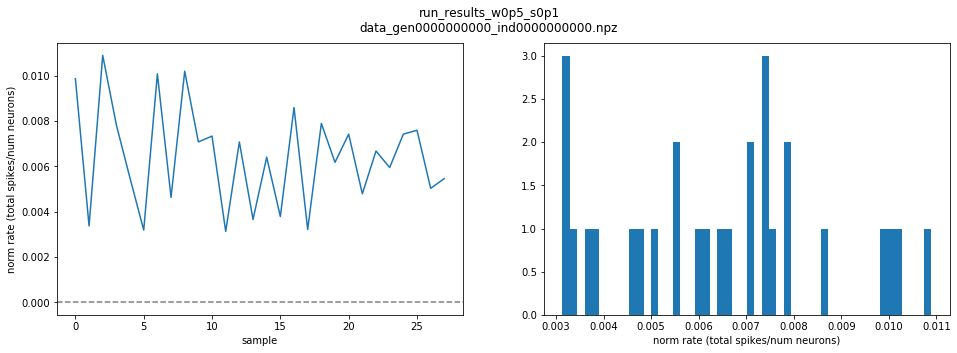

In [6]:
for dd in data:
    for ff in data[dd]:
        bs = data[dd][ff]
        rates = norm_rate(bs)
        plt.figure(figsize=(16, 5))
        ax = plt.subplot(1, 2, 1)
        plt.suptitle(f"{dd}\n{ff}")
        plt.axhline(0.0, linestyle='--', color='gray')
        plt.plot(rates)
        ax.set_xlabel('sample')
        ax.set_ylabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

        ax = plt.subplot(1, 2, 2)
        plt.hist(rates, bins=50)
        ax.set_xlabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"hist_rates_{dd}_{ff}.png", dpi=150)

        plt.show()
        
        

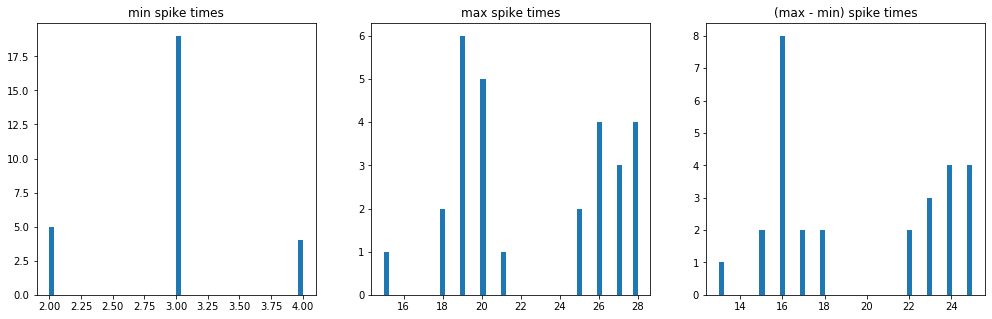

In [7]:
def get_delta_t_per_sample(bin_spikes, dt):
    dts = []
    mins = []
    maxs = []
    for i, bs in enumerate(bin_spikes):
        mint = np.min([np.min(ts) for ts in bs if len(ts)])
        maxt = np.max([np.max(ts) for ts in bs if len(ts)])
        mins.append(mint - i*dt)
        maxs.append(maxt - i*dt)
        dts.append( maxt - mint )
    return dts, mins, maxs

for dd in data:
    for ff in data[dd]:
        bs = data[dd][ff]
        dts, mins, maxs = get_delta_t_per_sample(bs, dt)
        
        plt.figure(figsize=(17, 5))
        ax = plt.subplot(1, 3, 1)
        ax.set_title(f"min spike times")
        plt.hist(mins, bins=50)
        
        ax = plt.subplot(1, 3, 2)
        ax.set_title(f"max spike times")
        plt.hist(maxs, bins=50)
        
        ax = plt.subplot(1, 3, 3)
        ax.set_title(f"(max - min) spike times")
        plt.hist(dts, bins=50)
        plt.savefig(f"hist_min_max_times.png", dpi=150)
        plt.show()
        
        

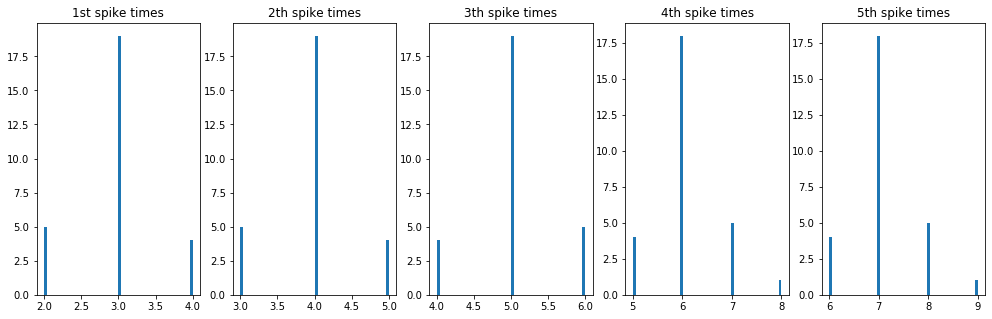

In [8]:
def get_first_n_per_sample(bin_spikes, dt, n=5):
    firsts = [[] for _ in range(n)]
    for i, bs in enumerate(bin_spikes):
        all_ts = set()
        for ts in bs:
            all_ts |= set(ts)
        sorted_ts = np.asarray(sorted(list(all_ts))) - dt * i
#         print(sorted_ts)
        for i, t in enumerate(sorted_ts):
            if i == n:
                break
            firsts[i].append(t)
            
    return firsts

for dd in data:
    for ff in data[dd]:
        bs = data[dd][ff]
        n = 5
        firsts = get_first_n_per_sample(bs, dt, n)
        
        plt.figure(figsize=(17, 5))
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            place = "st" if i == 0 else "th"
            ax.set_title(f"{i+1}{place} spike times")
            plt.hist(firsts[i], bins=50)
        
        plt.savefig(f"hist_spike_places.png", dpi=150)
        plt.show()
        
        

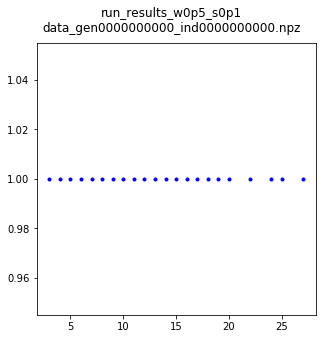

In [9]:
for dd in sorted(data.keys())[-1:]:
    for ff in sorted(data[dd].keys())[:1]:
        bs = data[dd][ff]
        uts = unique_times(bs, dt)
        
        plt.figure(figsize=(5, 5))
        ax = plt.subplot(1, 1, 1)
        plt.suptitle(f"{dd}\n{ff}")
        for ttt in uts[:1]:
            plt.plot(ttt, np.ones_like(ttt), '.b')
        plt.show()
        
        

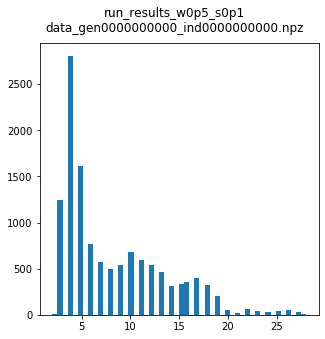

In [10]:
for dd in sorted(data.keys())[-1:]:
    for ff in sorted(data[dd].keys())[:]:
        bs = data[dd][ff]
        uts = relative_collapse_times(bs, dt)
        
        plt.figure(figsize=(5, 5))
        ax = plt.subplot(1, 1, 1)
        plt.suptitle(f"{dd}\n{ff}")

        plt.hist(uts, bins=50)
        plt.savefig(f"{dd}_{ff}.png", dpi=150)
        plt.show()
        
        

../titan/data_gen0000000000_ind0000000000.npz
54880
dict_keys(['labels', 'spikes', 'shapes', 'n_zones'])
num labels =   280
Futurama
['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness']
binned


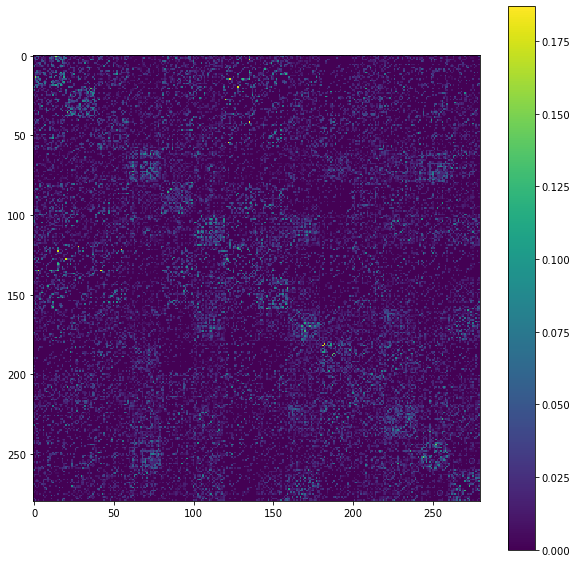

No handles with labels found to put in legend.


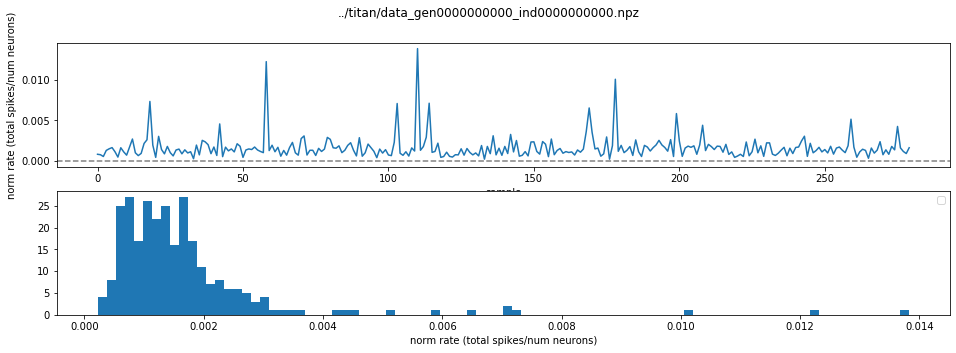

In [23]:
def bin_to_dict(bin_spikes, labels):
    un_lbl = np.unique(labels)
    vs = {l: [] for l in un_lbl}
    for i, s in enumerate(bin_spikes):
        v = [1 if len(spk) else 0 for spk in s]
        lbl = labels[i]
        vs[lbl].append(v)
    return vs
d = '../titan'
files = sorted(glob.glob(os.path.join(d, 'data*gen*00_*.npz')))
for i, n in enumerate(files):
    if 'Braille' in n:
        break

spikes = []
bs = []
rates = []
data = {}
for f in files:
    print(f)
    fname = os.path.basename(f)
    with np.load(f, allow_pickle=True) as npz:
        d = npz['db_name'].item()
#         if 'Braille' not in d:
#             continue
#             print(sorted(npz['recs'].item()['mushroom'][0]['spikes'].keys()))
        sim_ps = npz['params'].item()['sim']
        ind_ps = npz['params'].item()['ind']
#         pprint(sim_ps)
#         pprint(ind_ps)
        
        recs = npz['recs'].item()
        print( len(recs['mushroom'][0]['spikes']) )
        spikes = recs['mushroom'][0]['spikes']
#         break

        dt = sim_ps['sample_dt']
        n_class = sim_ps['num_classes']
        n_test = sim_ps['test_per_class'] * n_class
        duration = sim_ps['duration']
        inputs = npz['input'].item()
        print(inputs.keys())
        labels = inputs['labels']
        print('num labels =  ', len(labels))
#         spikes_dict = inputs['spikes'][0.0]
        print(d)
        print(list(npz.keys()))
        start_t = duration - n_test * dt
        end_t = start_t + n_test *  dt
        
        start_t = 0
        end_t = 14000#0
        start_idx = int(start_t // dt)
        end_idx = int(end_t // dt)
        
        bs = npz['binned'].item()['mushroom']#bin_spikes(spikes, dt, start_t,  end_t) 
        vs = bin_to_dict(bs, labels[start_idx:end_idx])
        print('binned')
#         lvs = [vs[k] for k in sorted(vs.keys())]
        n_samp = end_idx - start_idx
        over = np.ones((n_samp, n_samp)) * np.nan
        cls = sorted(vs.keys())
        lens = [len(vs[c]) for c in cls]
        acc_lens = []
#         for i0, c in enumerate(cls):
#             if i0 == 0:
#                 acc_lens.append(0)
#             else:
#                 acc_lens.append(lens[i0-1] + acc_lens[i0-1])

#         for i0, c0 in enumerate(cls):
#         #     print(i0)
#             for i1, c1 in enumerate(cls):
#                 if i1 < i0:
#                     continue
#         #         print(i0, i1)
#                 for j0, v0 in enumerate(vs[c0]):
#                     for j1, v1 in enumerate(vs[c1]):
#                         if j1 < j0:
#                             continue
#         #                 print(c0, c1, j0, j1, acc_lens[i0] + j0, acc_lens[i1] + j1)

#         #                         if c0 == c1 and j0 == j1:
#         #                             continue
#         #                         v = np.logical_and(v0, v1).sum()
#                         v0 = np.asarray(v0)
#                         v1 = np.asarray(v1)
#                         norm = np.sqrt((v0**2).sum() * (v1**2).sum())

#                         v = (v0 * v1).sum()/ norm if norm > 0 else np.nan
#         #                 print(v)

#                         over[acc_lens[i0] + j0, acc_lens[i1] + j1] = v
#                         over[acc_lens[i0] + j1, acc_lens[i1] + j0] = v
#                         over[acc_lens[i1] + j0, acc_lens[i0] + j1] = v
#                         over[acc_lens[i1] + j1, acc_lens[i0] + j0] = v
        over[:] = npz['correlations'].item()['mushroom']
        h, w = over.shape
        over[range(h), range(h)] = 0.
        plt.figure(figsize=(10, 10))
        plt.imshow(over.copy(), interpolation='none')#, cmap='gray')
        plt.colorbar()
        plt.show()

        lh_spikes = npz['recs'].item()['gain_control'][0]['spikes']
        lh_bins = bin_spikes(lh_spikes, dt, start_t, end_t)
        lh_rates = norm_rate(lh_bins)

        spikes_dict = npz['input'].item()['spikes'][0.0]
        bin_dict = {k: bin_spikes(spikes_dict[k], dt, start_t,  end_t) 
                    for k in spikes_dict}
        keys = sorted( bin_dict.keys() )
        k0 = keys[0]
        for k in keys[1:]:
            for bidx in range(len(bin_dict[k0])):
                for bl in bin_dict[k][bidx]:
                    bin_dict[k0][bidx].append(bl)

        in_rates = norm_rate(bin_dict[k0])
                
        rates = norm_rate(bs)
        
        nrates = (rates - np.mean(rates)) * (1./np.std(rates))
        max_norm = int(np.ceil(np.max(nrates)))
        nin_rates = (in_rates - np.mean(in_rates)) * (1./np.std(in_rates))
        nlh_rates = (lh_rates - np.mean(lh_rates)) * (1./np.std(lh_rates))

        plt.figure(figsize=(16, 5))
        ax = plt.subplot(2, 1, 1)
        plt.suptitle(f"{f}")
        plt.axhline(0.0, linestyle='--', color='gray')
        plt.plot(rates, label='KC')
#         plt.plot(in_rates, label='AL')
#         plt.plot(lh_rates, label='LH')
        
        ax.set_xlabel('sample')
        ax.set_ylabel('norm rate (total spikes/num neurons)')
        #         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

        ax = plt.subplot(2, 1, 2)
        plt.hist(rates, bins=(max_norm * 10))
        ax.set_xlabel('norm rate (total spikes/num neurons)')
        #         plt.savefig(f"hist_rates_{dd}_{ff}.png", dpi=150)
        plt.legend()
        plt.show()
          
#     break
#         rates = norm_rate(bs)
#         plt.figure(figsize=(16, 5))
#         ax = plt.subplot(1, 2, 1)
#     #     plt.suptitle(f"{ff}")
#         plt.axhline(0.0, linestyle='--', color='gray')
#         plt.plot(rates)
#         ax.set_xlabel('sample')
#         ax.set_ylabel('norm rate (total spikes/num neurons)')
#     #         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

#         ax = plt.subplot(1, 2, 2)
#         plt.hist(rates, bins=50)
#         ax.set_xlabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"hist_rates_{k}.png", dpi=150)

#         plt.show()



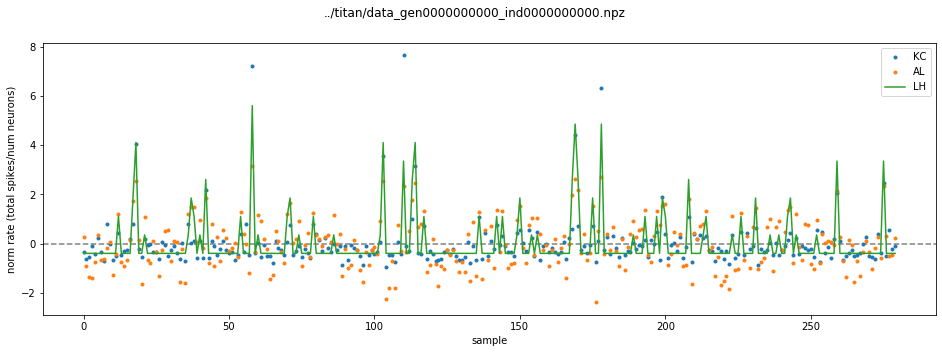

In [22]:
plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 1, 1)
plt.suptitle(f"{f}")
plt.axhline(0.0, linestyle='--', color='gray')
plt.plot(nrates, '.', label='KC')
plt.plot(nin_rates, '.', label='AL')
plt.plot(nlh_rates,  label='LH')

ax.set_xlabel('sample')
ax.set_ylabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

plt.legend()
plt.show()


In [7]:
1./5.


0.2

In [8]:
print(cls)
for i0, c0 in enumerate(cls):
#     print(i0)
    for i1, c1 in enumerate(cls):
        if i1 < i0:
            continue
#         print(i0, i1)
        for j0, v0 in enumerate(vs[c0]):
            for j1, v1 in enumerate(vs[c1]):
                if j1 < j0:
                    continue
#                 print(c0, c1, j0, j1, acc_lens[i0] + j0, acc_lens[i1] + j1)

#                         if c0 == c1 and j0 == j1:
#                             continue
#                         v = np.logical_and(v0, v1).sum()
                v0 = np.asarray(v0)
                v1 = np.asarray(v1)
                norm = np.sqrt((v0**2).sum() * (v1**2).sum())

                v = (v0 * v1).sum()/ norm if norm > 0 else 0
#                 print(v)

                over[acc_lens[i0] + j0, acc_lens[i1] + j1] = v
                over[acc_lens[i0] + j1, acc_lens[i1] + j0] = v
                over[acc_lens[i1] + j0, acc_lens[i0] + j1] = v
                over[acc_lens[i1] + j1, acc_lens[i0] + j0] = v

plt.figure()#figsize=(20, 20))
plt.imshow(over, interpolation='none')
plt.colorbar()
plt.show()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


IndexError: list index out of range